In [1]:
%run setup.ipynb

In [2]:
%matplotlib inline

## Preamble: how big a region should we use?

In [6]:
callset = phase1_ar31.callset
region_vgsc = SeqFeature('2L', 2358158, 2431617)
chrom = '2L'

In [7]:
@functools.lru_cache(maxsize=None)
def compute_information_gain(start_index=0, stop_index=200000):
    
    # load the data on cluster assignments
    import pickle
    with open('../data/clust_dict.pickle', mode='rb') as f:
        clust_dict = pickle.load(f)
        
    # define the classes - 'WT' means any susceptible
    classes = ['WT'] + sorted(clust_dict)
    n_classes = len(classes)
    
    # load haplotypes
    callset_phased = phase1_ar31.callset_phased
    haps = allel.GenotypeArray(callset_phased[chrom]['calldata/genotype'][start_index:stop_index, :765]).to_haplotypes()
    n_haps = haps.shape[1]
    pos = allel.SortedIndex(callset_phased[chrom]['variants/POS'][start_index:stop_index])
    
    # set up target attribute
    target_attr = np.zeros(n_haps, dtype=int)
    for i, cls in enumerate(classes):
        if i > 0:
            hap_indices = sorted(clust_dict[cls])
            target_attr[hap_indices] = i
            
    # compute entropy for the target attribute
    target_freqs = np.bincount(target_attr, minlength=n_classes) / target_attr.shape[0]
    target_entropy = scipy.stats.entropy(target_freqs)
    
    # setup output array
    gain = np.zeros(pos.shape[0])
    
    # work through the variants one by one
    for i in range(pos.shape[0]):
        
        # pull out the attribute data
        attr = haps[i]
        
        # split on attribute value and compute entropies for each split
        split_entropy = 0
        for v in 0, 1:
            split = target_attr[attr == v]
            if split.shape[0] == 0:
                continue
            split_freqs = np.bincount(split, minlength=len(classes)) / split.shape[0]
            split_entropy += (split.shape[0] / n_haps) * scipy.stats.entropy(split_freqs)
            
        # compute and store gain
        gain[i] = target_entropy - split_entropy
        
    return gain, pos, haps, target_attr

In [8]:
def plot_information_gain(start=None, stop=None, ax=None):
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 3))
        
    gain, pos, _, _ = compute_information_gain()    
    sns.despine(ax=ax, offset=5)
    ax.plot(pos, gain, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_xlabel('Position (bp)')
    ax.set_ylabel('Information gain')
    ax.set_xlim(start, stop)
    ax.set_ylim(bottom=0)
    if fig:
        fig.tight_layout()

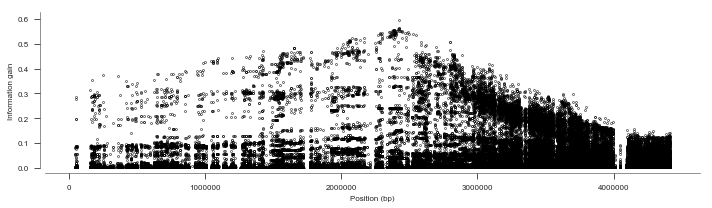

In [9]:
plot_information_gain()

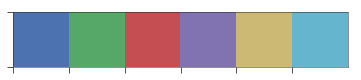

In [10]:
palette = sns.color_palette()
sns.palplot(palette);

In [14]:
def plot_diagnostics(chrom, start, stop, window_size, buffer=4e5):
    start, stop = int(start), int(stop)
    
    # setup data 
    pos = allel.SortedIndex(callset[chrom]['variants/POS'][:])
    filter_pass = callset[chrom]['variants/FILTER_PASS'][:]
    
    # extract region
    loc_region = pos.locate_range(start, stop)
    pos = pos[loc_region]
    filter_pass = filter_pass[loc_region]
    
    # make histogram
    bins = np.arange(start, stop, window_size)
    x = (bins[:-1] + bins[1:]) / 2
    h1, _ = np.histogram(pos, bins=bins)
    y1 = h1 / window_size
    h2, _ = np.histogram(pos[filter_pass], bins=bins)
    y2 = h2 / window_size
    
    # count how many variants within buffer region
    loc_selected = pos.locate_range(region_vgsc.start - buffer, region_vgsc.end + buffer)
    pos_selected = pos[loc_selected]
    filter_pass_selected = filter_pass[loc_selected]
    n_all = pos_selected.shape[0]
    n_pass = np.count_nonzero(filter_pass_selected)
    
    # setup figure
    fig = plt.figure(figsize=(10, 6), dpi=120)
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4])
    
    # plot genes
    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=5)
    plot_genes(phase1_ar3.genome, phase1_ar3.geneset_agamp42_fn, chrom='2L', start=start, stop=stop, ax=ax)
    ax.axvspan(region_vgsc.start - buffer, region_vgsc.end + buffer, zorder=-20, color='#dddddd')
    ax.axvspan(region_vgsc.start, region_vgsc.end, zorder=-20, color='#aaaaaa')
    ax.set_xlim(start, stop)

    # plot variant density
    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, offset=5)
    ax.fill_between(x, 0, y1, color=palette[2], lw=1, label='All (n=%s)' % n_all)
    ax.fill_between(x, 0, y2, color=palette[1], lw=1, label='Pass (n=%s)' % n_pass)
    ax.set_xlabel('Position (bp)')
    ax.set_ylabel('SNP density (per bp)')
    ax.axvspan(region_vgsc.start - buffer, region_vgsc.end + buffer, zorder=-20, color='#dddddd')
    ax.axvspan(region_vgsc.start, region_vgsc.end, zorder=-20, color='#aaaaaa')
    ax.set_xlim(start, stop)
    ax.set_ylim(0, 0.4)
    ax.legend(loc='upper left', ncol=1, frameon=True, framealpha=1)

    # plot information gain
    ax = fig.add_subplot(gs[2])
    plot_information_gain(start, stop, ax=ax)
    ax.axvspan(region_vgsc.start - buffer, region_vgsc.end + buffer, zorder=-20, color='#dddddd')
    ax.axvspan(region_vgsc.start, region_vgsc.end, zorder=-20, color='#aaaaaa')
    
    fig.tight_layout()

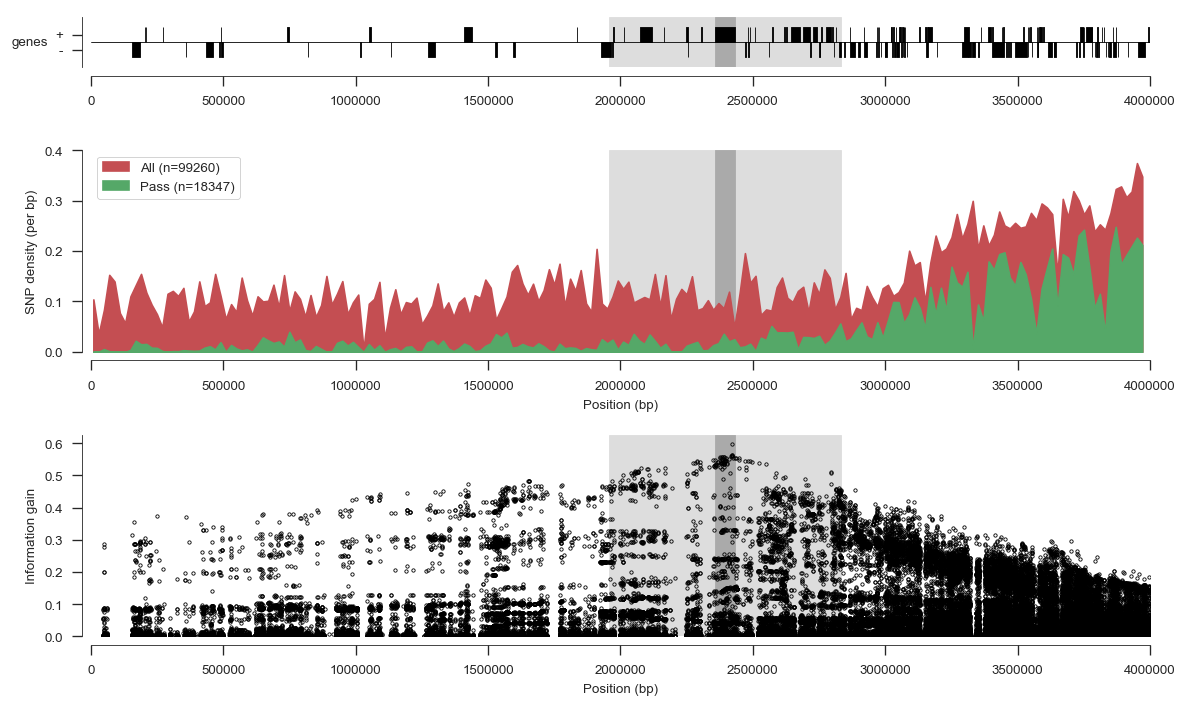

In [15]:
plot_diagnostics('2L', 1, 4e6, 2e4)

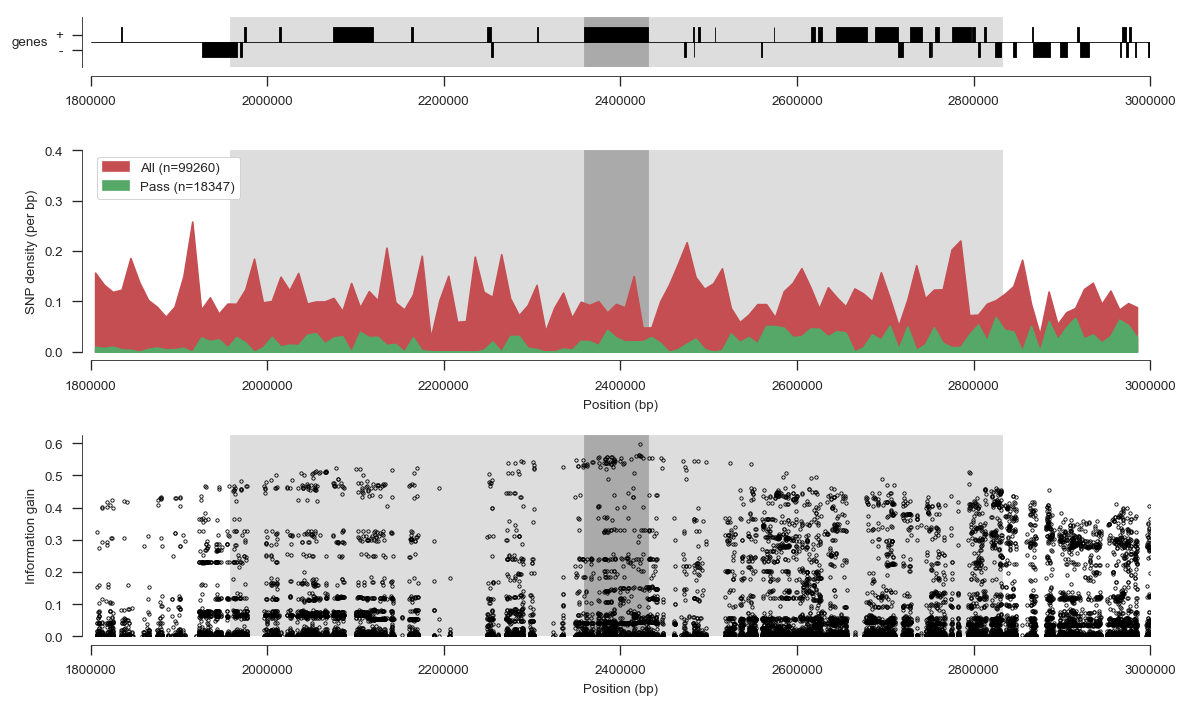

In [16]:
plot_diagnostics('2L', 1.8e6, 3e6, 1e4)

## Try building a decision tree

In [26]:
import sklearn.tree

In [19]:
gain, pos, haps, target = compute_information_gain()

In [20]:
# for starters, uses only SNPs inside the gene
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
loc

slice(24471, 26181, None)

In [21]:
data = haps[loc].T
data.shape

(1530, 1710)

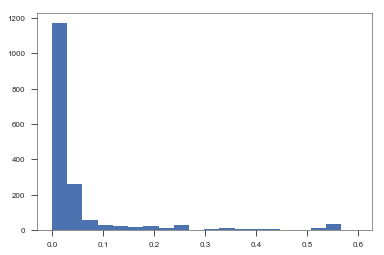

In [24]:
plt.hist(gain[loc], bins=20);

In [97]:
import sklearn.model_selection

In [100]:
clf.

10

In [108]:
@functools.lru_cache(maxsize=None)
def eval_trees(max_depths=tuple(range(2, 11)), min_samples_leaf=5, criterion='entropy', n_splits=10, random_state=42):
    
    # setup cross-validation
    skf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, random_state=random_state)
    
    # setup outputs
    scores = []
    n_features = []
    depths = []
    
    # interate with increasing maximum depth
    for max_depth in max_depths:
        
        # setup the classifier
        clf = sklearn.tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=random_state)
        
        # do cross-validation
        for train_index, test_index in skf.split(data, target):
            
            # split the data
            data_train, data_test = data[train_index], data[test_index]
            target_train, target_test = target[train_index], target[test_index]
            
            # fit the model
            clf.fit(data_train, target_train)
            
            # score the model
            scores.append(clf.score(data_test, target_test))
            
            # store depth and number of features
            depths.append(max_depth)
            n_features.append(np.count_nonzero(clf.feature_importances_))
            assert np.count_nonzero(clf.feature_importances_) == len(set(clf.tree_.feature[clf.tree_.feature >= 0]))

    scores = np.array(scores)
    n_features = np.array(n_features)
    depths = np.array(depths)
    return scores, n_features, depths
  
    
def repeat_eval_trees(max_depths=tuple(range(2, 11)), min_samples_leaf=5, criterion='entropy', n_splits=10, n_reps=5):
    scores = []
    n_features = []
    depths = []
    for i in range(n_reps):
        s, f, d = eval_trees(max_depths=max_depths, min_samples_leaf=min_samples_leaf, criterion=criterion, n_splits=n_splits, random_state=i)
        scores.extend(s)
        n_features.extend(f)
        depths.extend(d)
    scores = np.array(scores)
    n_features = np.array(n_features)
    depths = np.array(depths)
    return scores, n_features, depths
    

In [113]:
scores, n_features, depths = repeat_eval_trees(criterion='entropy', n_reps=10)

In [114]:
scores.shape

(900,)

In [115]:
n_features.shape

(900,)

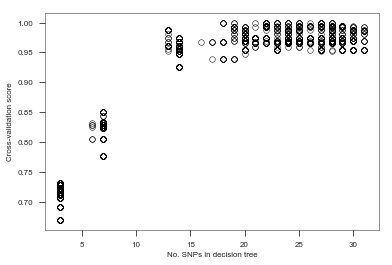

In [124]:
fig, ax = plt.subplots()
ax.plot(n_features, scores, marker='o', mfc='none', mec='k', linestyle=' ')
ax.set_xlabel('No. SNPs in decision tree')
ax.set_ylabel('Cross-validation score');


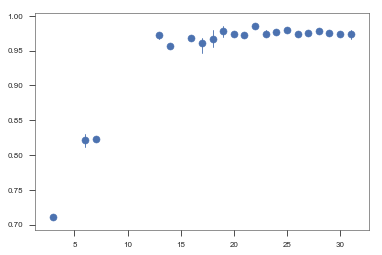

In [123]:
sns.regplot(n_features, scores, fit_reg=False, x_estimator=np.mean, ci=95);

In [75]:
scores.shape

(9, 10)

In [78]:
clf.get_params()

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [93]:
len(set(clf.tree_.feature[clf.tree_.feature >= 0]))

30

In [94]:
np.count_nonzero(clf.feature_importances_)

30

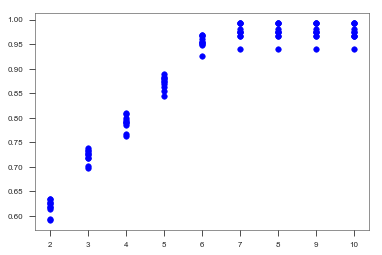

In [73]:
fig, ax = plt.subplots()
for x, y in zip(max_depths, scores):
    ax.plot([x] * len(y), y, 'bo')


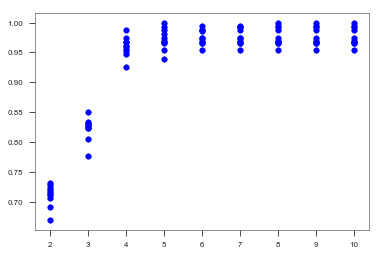

In [76]:
fig, ax = plt.subplots()
for x, y in zip(max_depths, scores):
    ax.plot([x] * len(y), y, 'bo')


In [27]:
clf = sklearn.tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5)

In [28]:
clf.fit(data, target)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [29]:
clf.predict_proba(data[:10])

array([[ 0.02811245,  0.97188755,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.02811245,  0.97188755,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.02811245,  0.97188755,  0.        ,  0.        ,  0.        ,
         0.        ,  

In [31]:
target[:10]

array([1, 1, 7, 1, 1, 1, 1, 1, 1, 7])

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
cross_val_score?

In [57]:
cross_val_score(clf, data, target, cv=10)

array([ 0.96855346,  0.99363057,  0.98709677,  0.97385621,  0.95424837,
        0.99346405,  0.97368421,  0.99337748,  0.96644295,  0.96621622])

In [35]:
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

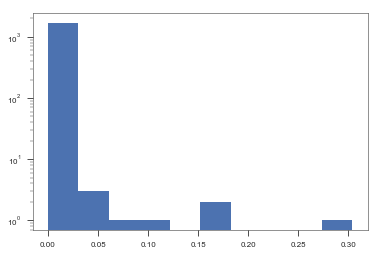

In [47]:
plt.hist(clf.tree_.compute_feature_importances())
plt.yscale('log');

In [48]:
np.count_nonzero(clf.tree_.compute_feature_importances())

30

In [50]:
np.count_nonzero(clf.feature_importances_)

30

In [56]:
clf.tree_

TypeError: decision_path() takes exactly one argument (0 given)

In [53]:
clf.tree_.feature

array([1530, 1529, 1048,   11,  441,  735,  354, 1085,   -2,  551,   -2,
         -2,  619,   -2,   -2,   -2,   -2,   -2, 1360,   -2,   -2, 1577,
       1248, 1285,   -2,   -2,   -2,    1, 1554,   -2, 1362,   -2,   -2,
         -2,  863,    6, 1042,   -2,  354,   -2,   -2, 1691, 1689, 1432,
       1696, 1687, 1673, 1674,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,  609, 1193,  626,   -2,   -2,   -2,   -2])

In [37]:
import graphviz

In [41]:
sklearn.tree.

In [38]:
dot_data = sklearn.tree.export_graphviz(clf, out_file=None)

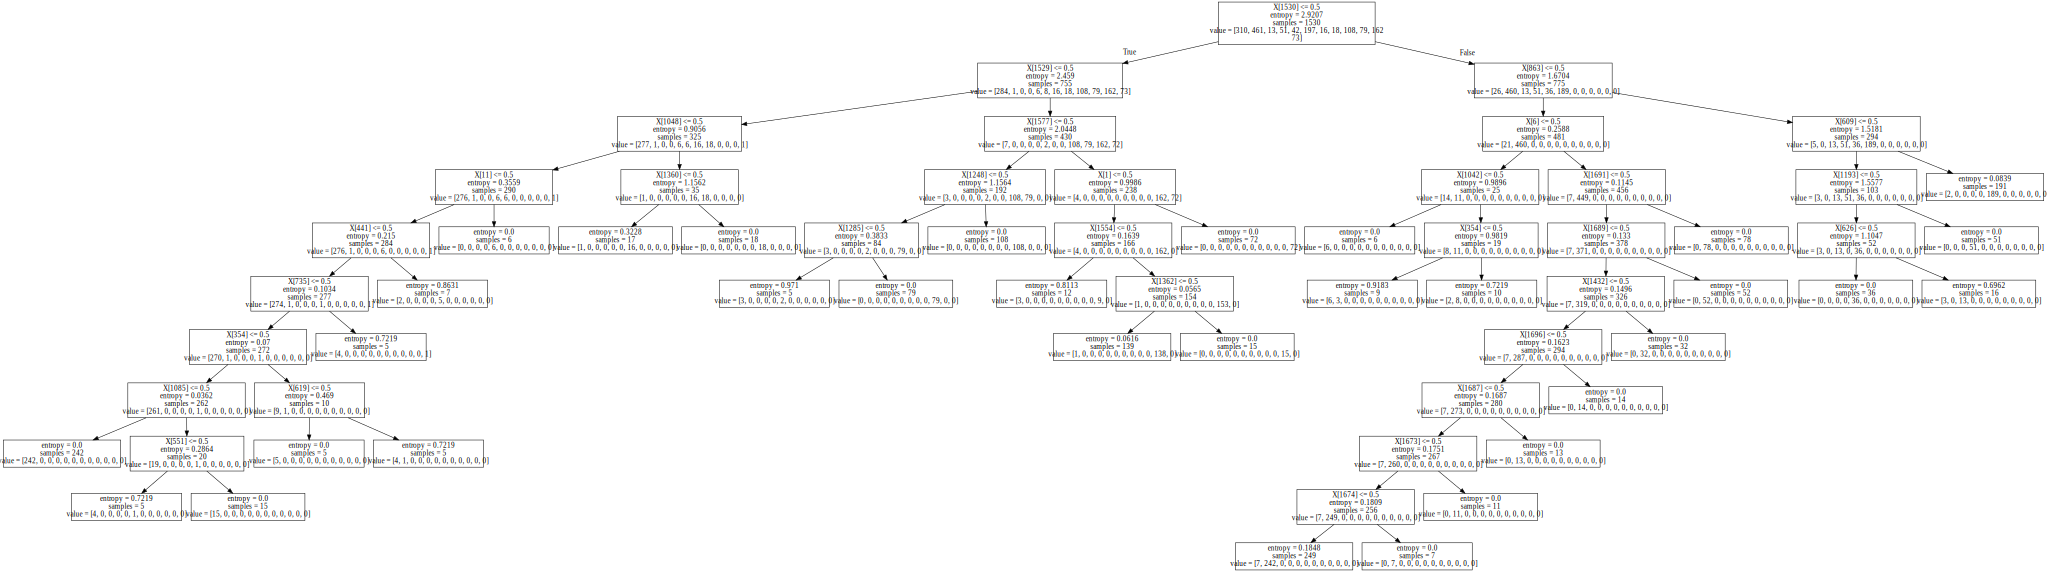

In [39]:
graph = graphviz.Source(dot_data)
graph